In [8]:
# relevant for lightning.ai studio
%cd del_mc1/


/teamspace/studios/this_studio/del_mc1


In [23]:
# base libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# ML related libraries
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import os

# mlops
import wandb

%env WANDB_NOTEBOOK_NAME=mc1.ipynb
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Tag ensure that wandb won't be cluttered
DEVELOPMENT = False
CUSTOM_TAGS = ['abgabe']

NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)

env: WANDB_NOTEBOOK_NAME=mc1.ipynb
env: CUBLAS_WORKSPACE_CONFIG=:4096:8
4


In [24]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 training data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
train_images, train_labels = next(iter(train_loader))

# Load CIFAR-10 test data
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_images, test_labels = next(iter(test_loader))


Files already downloaded and verified


Files already downloaded and verified


In [25]:

# Print shapes of the datasets to verify
print('train_images shape:', train_images.shape)
print('train_labels shape:', train_labels.shape)
print('test_images shape:', test_images.shape)
print('test_labels shape:', test_labels.shape)

# Accessing label names
# get all labels 
label_names = train_dataset.classes
print('label_names size:', len(label_names))
print('label_names:', label_names)


train_images shape: torch.Size([50000, 3, 32, 32])
train_labels shape: torch.Size([50000])
test_images shape: torch.Size([10000, 3, 32, 32])
test_labels shape: torch.Size([10000])
label_names size: 10
label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Exploratory Data Analysis 
This section provides some insight into the CIFAR-10 dataset, which will help ht

In [26]:
np.unique(train_labels, return_counts=True)[1], np.unique(test_labels, return_counts=True)[1]

(array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

The labels are well distributed.

Training Labels Distribution:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000

Test Labels Distribution:
airplane: 1000
automobile: 1000
bird: 1000
cat: 1000
deer: 1000
dog: 1000
frog: 1000
horse: 1000
ship: 1000
truck: 1000

Example Images from Each Class:


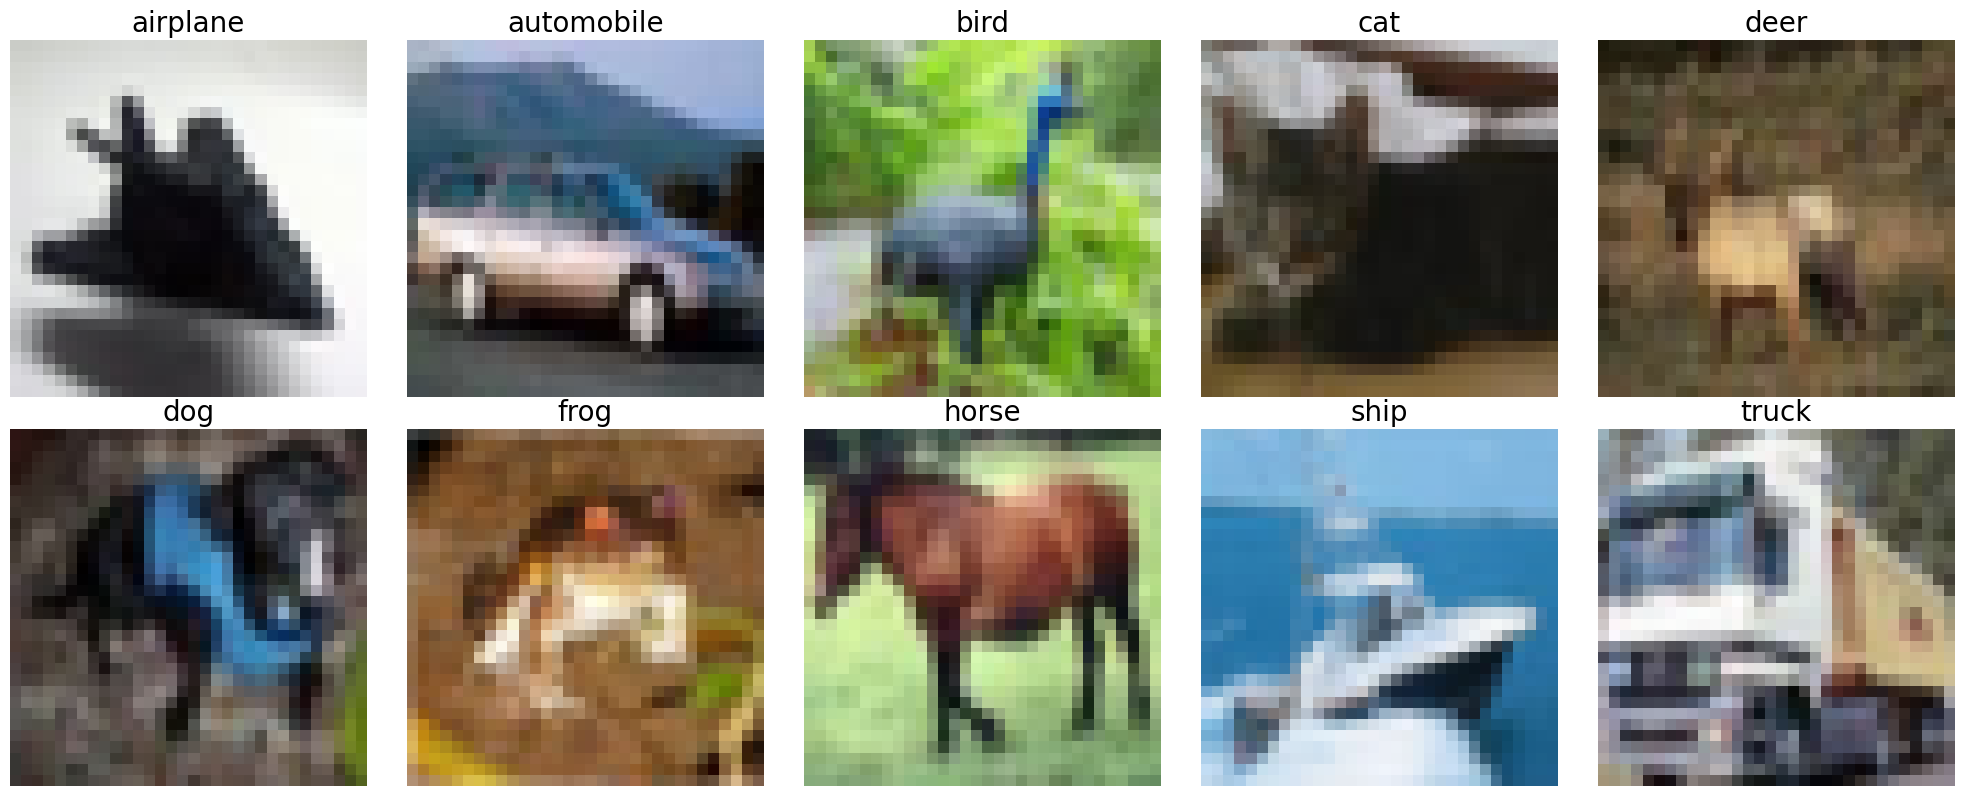

In [27]:

def verify_label_distribution(labels, label_names):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    for label, count in distribution.items():
        print(f'{label_names[label]}: {count}')
    return distribution

def display_example_images(images, labels, label_names):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, label_name in enumerate(label_names):
        index = np.where(labels == i)[0][0]
        image = images[index].permute(1, 2, 0) 
        
        axes[i].imshow(image)
        axes[i].set_title(label_name)
        axes[i].title.set_size(20)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
print("Training Labels Distribution:")
train_distribution = verify_label_distribution(train_labels, label_names)
print("\nTest Labels Distribution:")
test_distribution = verify_label_distribution(test_labels, label_names)

print("\nExample Images from Each Class:")
display_example_images(train_images, train_labels, label_names)


Let's calculate the mean and standard deviation for each color channel in the CIFAR-10 dataset.

#### Reasoning
This step is crucial for normalizing (relevant for preprocessing) the dataset, ensuring consistent model training and faster convergence.


In [28]:
def calculate_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

train_mean, train_std = calculate_mean_std(train_loader)
test_mean, test_std = calculate_mean_std(test_loader)

print(f"Training Mean: {train_mean}, Training Std: {train_std}")
print(f"Test Mean: {test_mean}, Test Std: {test_std}")


Training Mean: tensor([0.4914, 0.4822, 0.4465]), Training Std: tensor([0.2470, 0.2435, 0.2616])
Test Mean: tensor([0.4942, 0.4851, 0.4504]), Test Std: tensor([0.2467, 0.2429, 0.2616])


Let's plot histograms of pixel values for the Red, Green, and Blue channels.

#### Reasoning
Understanding pixel intensity distribution aids in identifying dataset biases and informs necessary preprocessing adjustments.


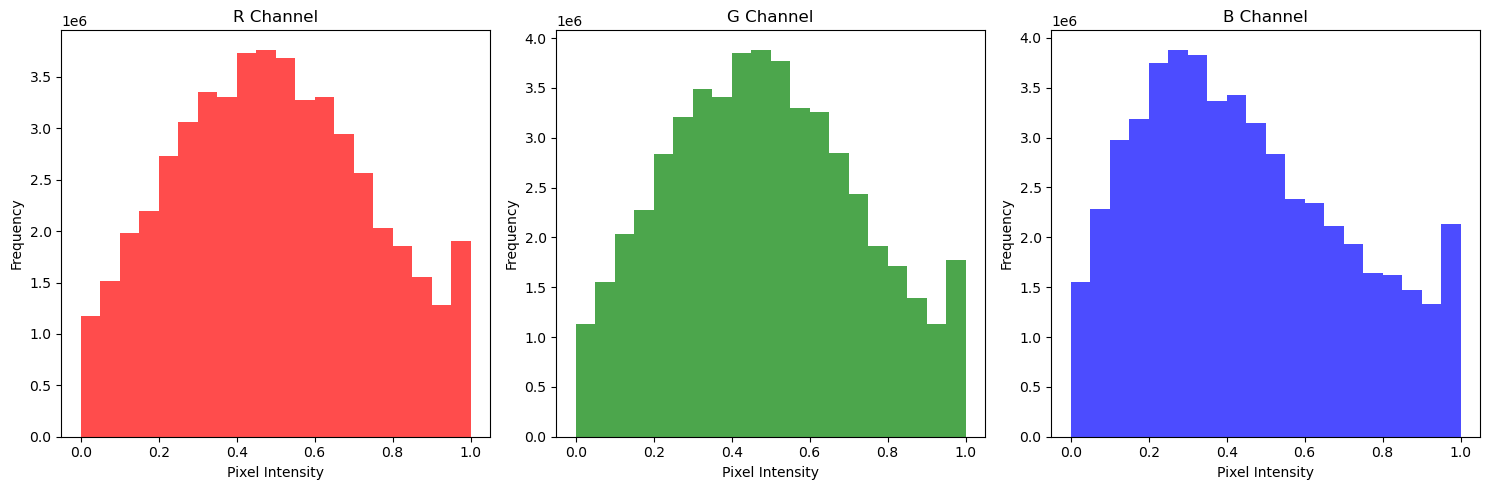

In [29]:
def plot_pixel_histograms(images):
    images = images.permute(1, 0, 2, 3).reshape(3, -1)
    plt.figure(figsize=(15, 5))
    for i, color in enumerate(['r', 'g', 'b']):
        plt.subplot(1, 3, i + 1)
        plt.hist(images[i].numpy(), bins=20, color=color, alpha=0.7)
        plt.title(f'{color.upper()} Channel')
        plt.ylabel('Frequency')
        plt.xlabel('Pixel Intensity')
    plt.tight_layout()
    plt.show()

plot_pixel_histograms(train_images)


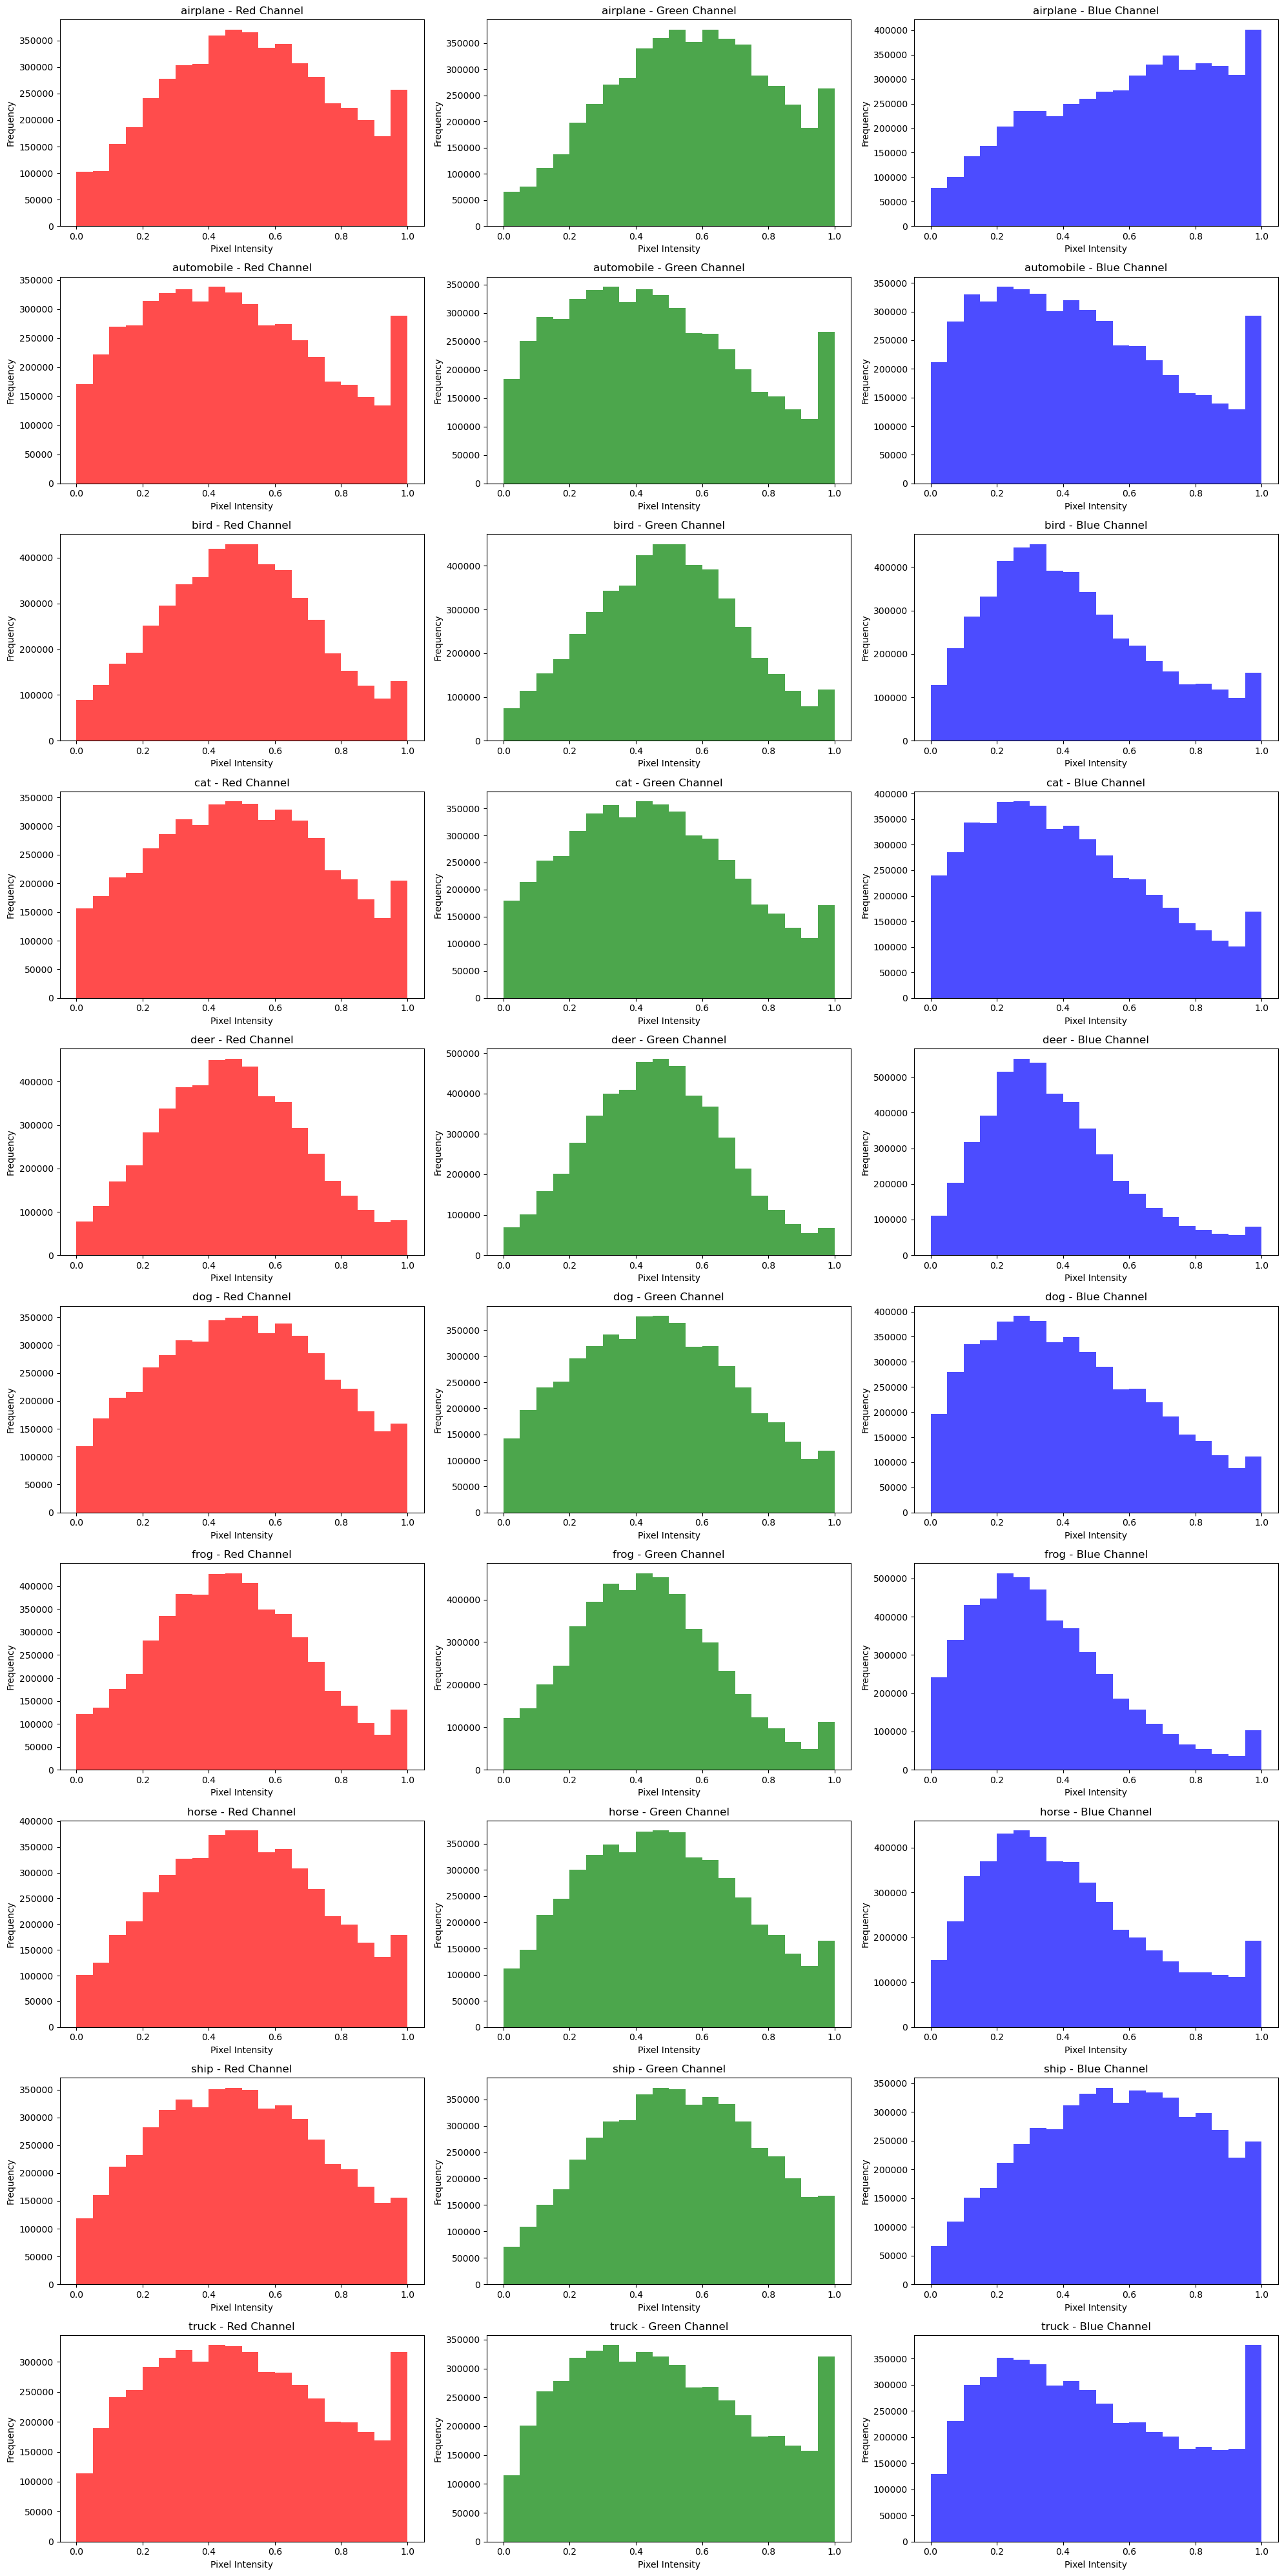

In [30]:
def plot_color_distribution_per_class(images, labels, label_names):
    num_classes = len(label_names)
    fig, axes = plt.subplots(nrows=num_classes, ncols=3, figsize=(20, num_classes * 4))
    
    for i, label_name in enumerate(label_names):
        class_images = images[labels == i]
        # Flatten the images to a single dimension per channel for plotting
        red_channel = class_images[:, 0, :, :].flatten()
        green_channel = class_images[:, 1, :, :].flatten()
        blue_channel = class_images[:, 2, :, :].flatten()
        
        for j, (channel, color) in enumerate(zip([red_channel, green_channel, blue_channel], ['Red', 'Green', 'Blue'])):
            ax = axes[i, j]
            ax.hist(channel.numpy(), bins=20, color=color.lower(), alpha=0.7)
            ax.set_title(f'{label_name} - {color} Channel')
            ax.set_xlabel('Pixel Intensity')
            ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


plot_color_distribution_per_class(train_images, train_labels, label_names)


## Preprocessing 


Given that the CIFAR-10 dataset is very well maintained (already labeled, pictures dimensions are consistent and distribution between labels is the same) the only thing we really need to do is properly normalize the data and do some train, validation and test split relevant for training later.

In [12]:
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std), # using training mean and std for normalization
])

# Reload the datasets with normalization, keep it simple
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=normalize_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform)


Files already downloaded and verified
Files already downloaded and verified


### 3. Modeling structure

The metric used for evaluation in this challenge will be Accuracy. While simple, it is a good metric given that the dataset is very well balanced. 

Since this is a multi-class classification, using cross-entropy as the loss function is logical. 

In [13]:

wandb.login()

api = wandb.Api()

class ModelTrainer:
    def __init__(self, model, train_dataset, test_dataset, optimizer, criterion=torch.nn.CrossEntropyLoss(), batch_size=128, epochs=30, seed=None, experiment="development", track=True, run_name=''):
        self.seed = seed    
        if seed is not None:
            self.set_seed(seed)

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.experiment = experiment
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.model.initialize_weights()

        self.config = self.auto_generate_config()
        self.track = track
        if self.track:
            self.run_name = run_name
            self.init_wandb()

    def set_seed(self, seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)

    def auto_generate_config(self):
        self.lr = self.optimizer.param_groups[0]['lr']
        config = {
            'model_type': self.model.__class__.__name__,
            'experiment': self.experiment,
            'optimizer': self.optimizer.__class__.__name__,
            'learning_rate': self.lr,
            'criterion': self.criterion.__class__.__name__,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'device': self.device,
            'seed': self.seed,
            'trainable_params': sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        }
        return config

    def init_wandb(self):
        if not self.run_name:
            self.run_name = f"{self.config['model_type']}_LR{self.config['learning_rate']}_BS{self.config['batch_size']}"

        tags = [self.config['experiment']]
        if DEVELOPMENT:
            tags.append('development')
        
        if CUSTOM_TAGS:
            tags.extend(CUSTOM_TAGS)

        wandb.init(project='del', name=self.run_name, group=self.config['experiment'], config=self.config, tags=tags)
        wandb.watch(self.model, self.criterion, log='all', log_freq=10, log_graph=True)

    def train(self, validate=False):
        self.model.train()
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        total_steps = len(train_loader)
        
        for epoch in range(self.epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # L1 reg is not supported by PyTorch optimizers natively
                if hasattr(self.model, 'l1_penalty'):
                    l1_loss = self.model.l1_penalty()
                    loss += l1_loss

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

            epoch_loss = running_loss / total_steps
            epoch_accuracy = correct_predictions / total_predictions
            if self.track:
                wandb.log({'epoch': epoch + 1, 'train_loss': epoch_loss, 'train_accuracy': epoch_accuracy})
            print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

            if validate:
                self.validate_epoch(epoch)

    def validate_epoch(self, epoch):
        self.model.eval()
        valid_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(valid_loader)
        accuracy = correct_predictions / total_predictions
        if self.track:
            wandb.log({'validation_loss': avg_loss, 'validation_accuracy': accuracy, 'epoch': epoch + 1})
        print(f'Validation - Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    def test(self):
        self.model.eval()
        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(test_loader)
        accuracy = correct_predictions / total_predictions
        if self.track:
            wandb.log({'test_loss': avg_loss, 'test_accuracy': accuracy})
        print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    def run(self, validate=True):
        self.train(validate=validate)
        # we either validate or test, as they share the same test set, so doing both is redundant.
        if not validate:
            self.test()
        if self.track:
            w_run = wandb.run
            wandb.finish()
            return w_run


wandb: Currently logged in as: dmnkf. Use `wandb login --relogin` to force relogin


In [14]:
class BasicCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=10, layers=None):
        super(BasicCNN, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
 
        if layers is None:
            self.layers = [
                nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                nn.Conv2d(32, 96, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Flatten(),
                nn.Linear(96 * 8 * 8, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes),
            ]
        else:
            self.layers = layers

        self.features = nn.Sequential(*self.layers)
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):             
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
# print total trainable features
model = BasicCNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total Trainable Parameters: {total_params}')

The `BasicCNN` class provided here is designed as a simple convolutional neural network (CNN) suitable for image classification tasks. The model architecture is chosen to offer a balanced approach between complexity and performance, making it well-suited for tasks that do not require extremely deep networks. It will serve as the base foundation for all following experiments and analysis.


1. **Layer Configuration**: It starts with an initial convolutional layer that takes in images with `input_channels` (defaulting to 3 for RGB images) and outputs 32 feature maps, using a kernel size of 3x3, stride of 1, and padding of 1 to preserve spatial dimensions. This is followed by a ReLU activation function for non-linearity and a max pooling layer to reduce the spatial dimensions by half, enhancing feature extraction while reducing computational load.

2. **Further Convolution and Pooling**: The process is repeated with another convolutional layer increasing the feature maps to 96, followed by ReLU and max pooling. This further helps in capturing more abstract features from the input images while continually reducing data dimensionality.

3. **Flattening and Output**: The network flattens the output of the last pooling layer and feeds it into a fully connected (linear) layer that maps the features to first 64 and then the `num_classes`, which represent the final classification scores for each class.

4. **Weight Initialization**: The model uses He initialization (`kaiming_uniform_`) for convolutional and linear layers to ensure the initial weights are scaled appropriately, reducing the chance of vanishing or exploding gradients, especially important in networks with ReLU activations. (comparison follows)


### Overfit check

To ensure that the model is capable of learning, the following block will train on a single batch (32 images) for train and test. The expectation here is that the model should overfit the train dataset quite easily hitting a perfect accuracy of 1.0. The train loss should smoothly converge to 0, whereas the validation loss will most likely increase over time. However given the small subset, the validation loss and accuracy should be bad as the model should overfit on train data and pick up every bit of noise so that it no longer is capable of generalizing unseen data.

In [ ]:
bs = 32

model = BasicCNN()
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_subset = torch.utils.data.Subset(train_dataset, range(bs))
test_subset = torch.utils.data.Subset(test_dataset, range(bs))
trainer = ModelTrainer(model=model, train_dataset=train_subset, test_dataset=test_subset, optimizer=optimizer, experiment='overfit', epochs=30, batch_size=bs, seed=55, track=True)

trainer.run()

In [17]:
%wandb dmnkf/del/reports/Overfit--Vmlldzo3NTc2NzQx

#### Results

The results do align with my theory and understanding. Looking at the train loss we can see how it quickly converges and is hitting a very high train accuracy. The validation loss on the other hand is not smooth at all since the

## Baseline Model 

For the upcoming experiments and analysis, we will be training the BasicCNN once to serve as baseline for comparisons at each point. The results of this training will be included in every following report of the notebook. Doing this here improves the overall training time as we are reuse the results from this run instead of rerunning it at every step.

The defaults defined here will be used for all upcoming runs if not specified differently.

In [15]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
EPOCHS = 30

In [ ]:
model = BasicCNN()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='baseline', epochs=EPOCHS, batch_size=BATCH_SIZE, seed=55, track=True, run_name=f'baseline_LR{LEARNING_RATE}_BS{BATCH_SIZE}')

trainer.run()

## Training with SGD, without REG, without BN



### Weight Initialisation
Weight initialisation refers to the process of assigning initial values to the weights of a network's neurons. This setup is crucial because it significantly influences the learning process and the model's performance. Proper initialisation can help avoid issues such as vanishing gradients, where updates to weights become insignificantly small during training, potentially halting the learning process.

**Key Points:**
- **Vanishing Gradient**: This problem can slow down the training or prevent convergence by making updates to the weights too small.
- **Convergence Speed**: Good initialisation methods can speed up convergence by ensuring weights start at a scale that prevents early saturation of neurons.
- **Local Minima**: Properly initialized weights can help the model avoid getting stuck in less optimal local minima during training.

Standards for weight initialization have evolved based on the activation function used in the network. For networks using ReLU activations, He Initialization, which adjusts weights based on the number of incoming nodes to a neuron, is considered best practice. 

**PyTorch Implementation:**
PyTorch applies He initialization for Linear and Conv layers tailored to LeakyReLU activations by default (`gain = sqrt(2 / (1 + negative_slope^2))` the negative slope being `sqrt(5)`). 

[Relevant PyTorch Source Code](https://arc.net/l/quote/juevbrgc)

#### Experiments

To better understand the impact of weight initialisation and its implication we will look at a variety of different initialisations down below and compare them. Given the initialisation done there are different expected outcomes which will then be analysed at the end. 


In [ ]:
class OneWeightCNN(BasicCNN):

    def __init__(self, input_channels=3, num_classes=10, layers=None):
        super().__init__(input_channels, num_classes, layers)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 1.0)
            

model = OneWeightCNN()
model.initialize_weights()

# Validate that all weights are set to 1
for name, param in model.named_parameters():
    if "weight" in name:  # Ensure we're only checking weights, not biases
        assert torch.all(param == 1), f"{name} not all ones"
print("All weights verified as 1.")


optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='weight_init', seed=55, track=True, run_name='OneWeightCNN')
trainer.run()

In [ ]:
class RandomWeightCNN(BasicCNN):

    def __init__(self, input_channels=3, num_classes=10, layers=None):
        super().__init__(input_channels, num_classes, layers)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                # Initialize weights with a uniform distribution
                nn.init.uniform_(m.weight, -0.1, 0.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

model = RandomWeightCNN()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='weight_init', seed=55, track=True, run_name='RandomWeightCNN')
trainer.run()

In [ ]:
class DefaultWeightCNN(BasicCNN):

    def __init__(self, input_channels=3, num_classes=10, layers=None):
        super().__init__(input_channels, num_classes, layers)

    def initialize_weights(self):
        for layer in self.layers:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()



model = DefaultWeightCNN()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='weight_init', epochs=EPOCHS, batch_size=BATCH_SIZE, seed=55, track=True, run_name="DefaultCNN")
trainer.run()

#### Models 
The baseline model was trained using 3 other weight initialisation:

- OneWeightCNN: All weights initialized strictly with 1
- RandomWeightCNN: Random weights sampled from an uniform distribution from -0.1, 0.1
- DefaultCNN: BasicCNN with a default PyTorch implementation (Kaiming He init from Uniform with gain for LeakyReLU activation function)

- Baseline: Weights initialized with Kaiming He init with gain for ReLU activation function.

In [18]:
## plot wandb weight_init report

%wandb dmnkf/del/reports/Weight-Initialisation--Vmlldzo3NTQwNjI1 -h 1024

#### Observations
- The train loss decreases the fastest with the baseline model
- Initializing all weights with 1 results in very poor performance with a high static loss and low performance.
- The test score for default, random and baseline (He ReLU) all convergence at slightly different speeds on train, do however achieve similar validation loss and accuracy all within 3% difference. 

#### Analysis
- Initializing all weights with 1 performs as expected with a poor performance. The understanding here is that setting all weights to the same value results in the neurons behaving in the same way which is unwanted.
- DefaultCNN and baseline performing similar also makes sense, as they essentially do the same initialization with a slightly different gain. 
- RandomCNN performs well since the sample distribution range is rather small (-0.1, 0.1) allowing to break symmetry which allows in the model learning.


### Hyperparameter Tuning
Für jedes Modell mit gegebener Anzahl Layer und Units pro Layer führe ein sorgfältiges Hyper-Parameter-Tuning durch. Untersuche, wie sich die das Training verändert bei unterschiedlicher Wahl für die Lernrate, in einer separaten Betrachtung auch für die Batch-Grösse. Achte stets darauf, dass das Training stabil läuft. Merke Dir bei jedem Training, den Loss, die Performance Metrik(en) inkl. Schätzfehler, die verwendete Anzahl Epochen, Lernrate und Batch-Grösse. Beachte: Keine Verfahren zur automatischen Hyperparameter-Suche (z.B. kein Bayesian und kein Random Parameter- Sweep Methoden) verwenden!

#### Learning Rate 



In [ ]:
learning_rates = [1, 0.1, 0.001, 0.0001]

for lr in learning_rates:
    model = BasicCNN()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='learning_rate', seed=55, track=True, run_name=f"LR{lr}")
    trainer.run()

In [19]:
%wandb dmnkf/del/reports/Learning-Rate--Vmlldzo3NTQ3Mzgz

#### Observations
- The best validation accuracies were achieved with a learning rate 0.1 and the baseline (0.01). Both of them appear to be more wiggly on validation
- Learning rate of 1 leads to the train loss not being able to be calculated as it appears to be too big. 
- Lower learning rates like 0.001 and 0.0001 result in smoother convergence for train and validation loss. They also converge slower.
- LR 0.001 and baseline (0.01) achieve a similar validation loss, which does not translate to the validation accuracy with ~8% difference (0.68 vs 0.60)
- LR 0.1 has an increase in validation loss after epoch 6-7 indicating overfitting. This is further confirmed with the train loss being almost 0 at the end.


#### Interpretation
The results here align with the theory. 
- Lower learning rates result in slower learning, as the steps taken by SGD are smaller, this has the consequences of requiring longer training (more epochs) to achieve a similar train loss as higher learning rates. 

- High learning rates like 0.1 overshoot the optimal values, leading to instability which can be seen by the wiggly validation loss. Also the pattern of overfitting can be seen here, which means that the model is learning too much from the training,  resulting in poor performance on unseen data. 

- So while higher learning rates take fewer epochs to reach certain loss/accuracies, they come with trade offs like unstable losses. A good learning rate should convergence at a good speed, while not overfitting too fast, hence the choice of using LR0.01 for the baseline.

- Learning rate 1 leading to nan losses may be an exploding gradient problem which is artifically caused due to the large learning rate resulting in overshooting.  


### Batch Sizes

In [ ]:

batch_sizes = [1000, 64, 32, 16]


for bs in batch_sizes:
    model = BasicCNN()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='batch_size', batch_size=bs, seed=55, track=True, run_name=f"BS{bs}")
    trainer.run()

In [20]:
%wandb dmnkf/del/reports/Batch-Size--Vmlldzo3NTQ3Mzgw -h 1024

#### Observations
- The best validation accuracy was reached by BS16 and BS32
- There is a roughly linear correlation between batch size and processing time.
- Batch size 64 has some rather odd spikes in validation loss, which are not appearing to that extreme in baseline (batch size 128) or BS32.
- Lower batch sizes (16 and 32) show signs of overfitting with increase of validation loss after epoch 5-8 and a train loss of almost 0 towards the end of training (epoch 25+)
- Larger batch sizes like BS1000 converge slower, but finish faster (processing time)
- Smaller batch size (32 and 16) are faster at converging and hitting high train accuracies. 
 
#### Interpretation
The results here align with the theory:
- Smaller batch sizes directly translate to more updates per epoch. This is because for every epoch the dataset is split into batches according to the batch size. Every batch is then processed in the training algorithm, and weights are updated post each batch, leading to potentially faster learning initially due to more frequent updates. This explains the computational time and overfitting for the lower batch sizes. Theoretically adjusting the epochs will circumvent this as with more updates the training doesn't need as manz epochs to reach certain loss/accuracy levels.

- The odd spikes for BS64 in the validation loss may indicate a suboptimal combination of learning rate and batch size which results in correcting direction too aggressively, leading to unstable training dynamics. Adjusting the learning rate could perhaps improve this.

- Given all of this batch size of 128 for the baseline model can be kept as it converges at a decent speed per epoch while not taking too much time to train.

## Complexity
Variiere die Anzahl Layer und Anzahl Units pro Layer, um eine möglichst gute Performance zu erreichen. Falls auch CNNs (ohne Transfer-Learning) verwendet werden variiere auch Anzahl Filter, Kernel-Grösse, Stride, Padding.

To simplify the training of different complexities without generating too much code I wrote the create_model function which will generate the model given a configuration.

In [16]:
def create_model(conv_channels, kernel_size, stride, padding,
                 input_channels=3, num_classes=10, input_size=32, linear_layer_sizes=[]):
    num_conv_layers = len(conv_channels)
    assert all(len(layer) == len(conv_channels[i]) for i, layer in enumerate(kernel_size)), "Each layer's kernel_size must match its conv_channels"
    assert all(len(layer) == len(conv_channels[i]) for i, layer in enumerate(stride)), "Each layer's stride must match its conv_channels"
    assert all(len(layer) == len(conv_channels[i]) for i, layer in enumerate(padding)), "Each layer's padding must match its conv_channels"

    layers = []
    channels_in = input_channels
    current_size = input_size

    # Building convolutional layers
    for i in range(num_conv_layers):
        for j in range(len(conv_channels[i])):
            layers.append(nn.Conv2d(channels_in, conv_channels[i][j], kernel_size=kernel_size[i][j], stride=stride[i][j], padding=padding[i][j]))
            layers.append(nn.ReLU())
            # Update current size based on conv
            current_size = (current_size + 2 * padding[i][j] - kernel_size[i][j]) // stride[i][j] + 1
            channels_in = conv_channels[i][j]
            
        # Pooling layer size reduction
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        current_size = (current_size - 2) // 2 + 1

    layers.append(nn.Flatten())

    # Flattened size for the first linear layer
    current_size = current_size * current_size * channels_in

    # Build linear layers based on the sizes provided in linear_layer_sizes
    if linear_layer_sizes:
        for i, layer_size in enumerate(linear_layer_sizes):
            if i == 0:  # First linear layer after flattening
                layers.append(nn.Linear(current_size, layer_size))
            else:
                layers.append(nn.Linear(linear_layer_sizes[i-1], layer_size))
            layers.append(nn.ReLU())
        # Final layer to number of classes
        layers.append(nn.Linear(linear_layer_sizes[-1], num_classes))
    else:
        # Direct mapping from flattened to num_classes if no intermediate sizes are specified
        layers.append(nn.Linear(current_size, num_classes))

    return BasicCNN(input_channels, num_classes, layers)

### Filter Sizes

This experiment looks at different variations of filter sizes, using the same structure as the baseline BasicCNN. 

- 2 Convolutions Layers 
    (each with 1 convolution (kernel 3x3, stride 1 and padding 1), 
- ReLU activation
- 1 Maxpool(pool=2), 
- 64 FC, 
- ReLU,
- 10 FC -> (softmax is done by cross entropy class of PyTorch) ) 

Keeping this structure, but changing the filter sizes of the convolutions may result in improvements for the classification task at hand.

The names of the runs indicate its structure. So 32_16ch_64L means that the first convolutional layer creates 32 activation maps, which then are reduced to 16 by the second conv layer.

In [ ]:
model_128_128ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[128], [128]],  
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)

model_32_16ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [16]],
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)

model_128_256ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[128], [256]],
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)

model_96_512ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[96], [512]],
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)

filter_dict = {
    '128_128ch_64L': model_128_128ch,
    '32_16ch_64L': model_32_16ch,
    '128_256ch_64L': model_128_256ch,
    '96_512ch_64L': model_96_512ch
}

for name, model in filter_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='filter_size', batch_size=BATCH_SIZE, seed=55, track=True, run_name=name)
    trainer.run()

In [10]:
%wandb dmnkf/del/reports/Filter-Size--Vmlldzo3NTUyMzkz -h 1024

#### Observations
- The best validation accuracy was achieved with the 96_512_ch_64L model.
- The more complex models (based to trainable parameters) perform slightly better on the validation dataset at the cost of a higher runtime. They also appear to overfit (train loss close to 0), validation loss does not increase by a lot (very slight upwards shift).
- All the models reach different train losses (~0-0.78), however achieve similar validation loss and accuracies. (~0.97-1.1)
- 96_512_ch_64L has  a bigger spike in the valdiation loss at epoch 28.
- The simplest model (32_16ch_64L) reaches the lowest validation loss and also  the lowest validation accuracy.


#### Interpretation 
- Even though the most complex model did achieve the best validation accuracy, the improvement is not significant enough to justify the increase in trainable parameters and the resulting costly computational runtime. (3x times longer training and ~5x times more trainable parameter)
- The overfit on train should perhaps be looked at, maybe introducting some kind of regularization could improve the situation. 
- Given the similar validation performance across all models, it appears as if the 70% validation accuracy is some kind of threshold that can not be easily overcome by simply changing filter sizes. 
- The spike in validation loss at epoch 28 for the 96_512_ch_64L model could indicate an overfitting to training-specific noise, or possibly illustrating a double descent pattern (interpolation threshold), where further training or adjustment (like regularization or learning rate changes) could improve generalization. However it could also just be an outlier batch as all validation losses increased to some degree in that specific epoch.


### Convolutional Layers

Now that we looked filter sizes, we will take a closer look at possible alterations of the model structure, by introducing a variety of different convolutional layer counts and sizes.

The models looked at*:

"32_64_128ch_64L": 3 Conv Layer (Conv, ReLU, MaxPool) for 32, 64, then 128 maps -> FC64 -> ReLU
"128_256_512ch_64L": 3 Conv Layer (Conv, ReLU, MaxPool) for 128, 256, then 512 maps -> FC64 -> ReLU 
"96_256_256_512ch_64L": 4 Conv Layer (Conv, ReLU, MaxPool) for 128, 2x 256, then 512 maps -> FC64 -> ReLU 
"2_32_2_128ch_64L": 2 Conv Layer (Conv, ReLU, Conv, ReLU, MaxPool) for 32, then 128 maps -> FC64 -> ReLU

\* each model is finished by a FC10 -> Softmax ()

In [ ]:

# Channel Size Experiment with potential multiple convolutions per layer capability
model_32_64_128ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [64], [128]],  
    kernel_size=[[3], [3], [3]],
    stride=[[1], [1], [1]],
    padding=[[1], [1], [1]]
)

model_128_256_512ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[128], [256], [512]], 
    kernel_size=[[3], [3], [3]],
    stride=[[1], [1], [1]],
    padding=[[1], [1], [1]]
)

model_96_256_256_512ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[96], [256], [256], [512]], 
    kernel_size=[[3], [3], [3], [3]],
    stride=[[1], [1], [1], [1]],
    padding=[[1], [1], [1], [1]]
)

model_2_32_2_128ch = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32, 32], [128, 128]], 
    kernel_size=[[3, 3], [3, 3]],
    stride=[[1, 1], [1, 1]],
    padding=[[1, 1], [1, 1]]
)

layer_dict = {
    "32_64_128ch_64L": model_32_64_128ch,
    "128_256_512ch_64L": model_128_256_512ch,
    "96_256_256_512ch_64L": model_96_256_256_512ch,
    "2_32_2_128ch_64L": model_2_32_2_128ch,
}


for name, model in layer_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='conv_layers', seed=55, track=True, run_name=name)
    trainer.run()

In [ ]:
%wandb dmnkf/del/reports/Convolution-Layers--Vmlldzo3NTY1MTI1 -h 1024

#### Observations
- The best validation accuracy was achieved with the 128_256_512_ch_64L model.
- The 3 most complex models (according to trainable params) all show signs of overfitting with increase in validation loss after 15 epochs and near 0 train loss
- The more complex models (based to trainable parameters) perform slightly better on the validation dataset at the cost of a higher runtime. The exception being 2_32_2_128ch_64L which performs rather poorly and has strong signs of overfitting with an increasing validation loss towards the end. 
- The train and validation loss development of the simpler models (baseline and 32_64_128ch_64L) is pretty close.
- 2_32_2_128ch_64L appears to have a spike at epoch 29 in the validation loss plot.

#### Interpretation
- The increase in not only filter size but also convolutions layers appears to provide greater performance with the 2 most complex models achieving 0.72 accuracy on validation. This is not a significant improvement but showcases how complexity in not only increasing filter size but also conv layer in general can enhance performance. Regularization could further enhance model performances. 
- The spike in validation loss at epoch 29 for the 2_32_2_128ch_64L model could indicate an overfitting to training-specific noise, as the whole validation loss seems to be rather wiggly. 
- The rather poor result of 2_32_2_128ch_64L suggest that simply adding more convolutional to a conv layer does not guarantee better performance. A possible reason could be that this configuration does not effectively balance the depth and width needed to capture more complex patterns without overfitting. This model might benefit from a more thoughtful arrangement of convolutional layers or enhanced regularization techniques to mitigate the rapid learning of non-generalizable features.
- In general to prevent the overfitting, applying regularization, alterings learning rate and epochs could enhance the performance on a per model basis.


### Kernel Size

The kernel size in convolutional layers plays a pivotal role in determining how effectively a CNN captures spatial information and feature granularity from input images. Larger kernels encompass a broader view of the input at each convolution step, enabling the model to capture more global features within fewer layers. This can be advantageous for identifying larger patterns but may increase computational cost and risk overfitting due to the greater number of parameters. Conversely, smaller kernels focus on finer details and require more layers to achieve a comparable field of view, promoting sensitivity to local features without drastically increasing the parameter count.

The following experiment will look the baseline model BasicCNN and alter the kernel size for both convolutional layers. Paddings will be accordingly adjusted to not alter dimensions ("same").

The different models will then be compared to the baseline model (3x3, stride 1 and padding 1)

In [ ]:
model_1x1kern = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],
    kernel_size=[[1], [1]],  
    stride=[[1], [1]],
    padding=[[0], [0]]
)

model_5x5kern = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],
    kernel_size=[[5], [5]],  
    stride=[[1], [1]],
    padding=[[2], [2]]  
)

model_7x7kern = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],  
    kernel_size=[[7], [7]],  
    stride=[[1], [1]],
    padding=[[3], [3]]  
)

model_15x15kern = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],  
    kernel_size=[[15], [15]],  
    stride=[[1], [1]],
    padding=[[7], [7]]  
)



kernel_dict = {
    "1x1K_1S_0P": model_1x1kern,
    "5x5K_1S_2P": model_5x5kern,
    "7x7K_1S_3P": model_7x7kern,
    "15x15K_1S_7P": model_15x15kern,
}

for name, model in kernel_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='kernel_size', seed=55, track=True, run_name=name)
    trainer.run()


In [21]:
%wandb dmnkf/del/reports/Kernel-Size--Vmlldzo3NTQ3Mzg2

#### Observations
- Higher kernel sizes (15x15 and 7x7) tend to overfit, given validation loss increasing. The train loss of almost 0 for 15x15 further supports this.
- The best performance on validation appears to be baseline (3x3) and 5x5. However all models with the exception of 1x1 perform very similarily on validation.
- Kernel size 1x1 in general seems to underfit.

#### Interpretation
Given the nature of the dataset of CIFAR-10, which consists of 32x32 rgb images, the theory of smaller kernel sizes performing rather better holds up. However, the balance between local and global information extraction is critical. The smaller 1x1 kernel, which essentially performs a per-pixel transformation without capturing any spatial context, seems insufficient to model the complexity of the images effectively, leading to underfitting. On the other hand, larger kernels such as 7x7 and 15x15 may capture more spatial information but at the risk of overfitting, as evidenced by the low training losses and rising validation losses. These larger kernels are potentially too expressive for the relatively small image size of CIFAR-10, focusing on details that do not generalize well. Then again the performance for all is comparable. Adjusting not only kernel size but also conv layers could perhaps yield different results.

The moderate kernel sizes of 3x3 and 5x5 seem to provide a better balance by effectively capturing local contextual information without overly emphasizing specific image details, hence their stronger performance on validation. This suggests that for CIFAR-10, where each image is only 32x32 pixels, smaller but not minimal kernel sizes might be optimal for capturing the necessary features without learning too much noise. This aligns with my intuition.


### Stride

Stride defines the step size at which the kernel moves across the input image during a convolution operation in a convolutional neural network (CNN). Adjusting the stride affects how quickly the spatial dimensions of the output feature maps are reduced. A larger stride results in more aggressive down-sampling, reducing the output size quickly, which can decrease the computational load and speed up the processing time. However, a larger stride may also cause the network to miss finer details in the input, potentially leading to a loss in accuracy if important features are skipped. Conversely, a smaller stride tends to preserve spatial resolution better, capturing more detailed information but at the cost of increased computational complexity.

In this experiment we will be looking at changing the stride of our baseline CNN and understand its implications on the model performance.

In [ ]:
model_stride_2 = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],  
    kernel_size=[[3], [3]],      
    stride=[[2], [2]],           
    padding=[[1], [1]]           
)

model_stride_3 = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],  
    kernel_size=[[3], [3]],      
    stride=[[3], [3]],           
    padding=[[1], [1]]          
)


stride_dict = {
    "3x3K_2S_1P": model_stride_2,
    "3x3K_3S_1P": model_stride_3
}

for name, model in stride_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='stride_size', seed=55, track=True, run_name=name)
    trainer.run()


In [12]:
%wandb dmnkf/del/reports/Stride--Vmlldzo3NTQ3NDAx

#### Observations
- Strides above 1 tend decrease the baseline model performance.
- Both stride 2S and 3S show signs of underfitting.
- Looking at the trainable parameters we can see how much impact a bigger stride has on the dimensionality.

#### Interpretation
The observed decrease in performance with strides greater than 1 suggests that increasing the stride reduces the model's ability to effectively capture the detailed spatial relationships in the images of CIFAR-10. Strides of 2 and 3 lead to more aggressive downsampling of the input image, resulting in a significant reduction of the spatial resolution that the convolutional layers receive. This reduction likely causes the model to miss finer textures and patterns essential for accurate classification, hence the signs of underfitting. Increasing convolutions per layer could perhaps improve the situation, but given the trainable parameters of the models in comparison to the baseline model it appears that strides above 1 are overall damaging the baseline model. 

An other option would be to perhaps increase the kernel size to neutralize the dimensionality reduction and perhaps retain more features. However, this seems like a very niche application as properly used kernel sizes should already handle this.



### Padding
Padding defines the process of adding layers of zeros around the border of the input image before performing a convolution operation in a convolutional neural network (CNN). By implementing padding, the spatial dimensions of the output feature maps can be preserved, allowing for the retention of information at the edges of the input image. This preservation is crucial for maintaining the full field of view of the input, which is important when features of interest are located near the borders. Without padding, the spatial size of the output decreases with each convolution layer, potentially leading to loss of edge information. However, excessive padding can also introduce too much zero-padding, which might dilute the significance of actual input data and affect the learning process negatively. In summary, padding helps in managing the trade-off between losing information at the edges and increasing the dimensionality of the feature maps.

This experiment will showcase how the padding can impact the baseline model. For this the padding for the baseline model will deliberately set to 0, which introduces a small dimensionality reduction.

In [ ]:
model_0pad = create_model(
    linear_layer_sizes=[64],
    conv_channels=[[32], [96]],  
    kernel_size=[[3], [3]],      
    stride=[[1], [1]],           
    padding=[[0], [0]]           
)

padding_dict = {
    "3x3K_1S_0P": model_0pad,
}

for name, model in padding_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='padding', seed=55, track=True, run_name=name)
    trainer.run()

In [22]:
%wandb dmnkf/del/reports/Padding--Vmlldzo3NTg2MTU2

#### Observations
- Padding 0 is slightly worse across all metrics except running time.
- Padding 0 results in roughly 40% reduction in feature in comparison to the baseline model.
    - This however does not result in a similar running time reduction. (90s vs 86s)
- Even with the reduction is the valdiation loss and accuracy between the two comparable with not even 1% difference in accuracy.


#### Interpretation
The observations suggest that while using padding of 0 reduces the spatial dimensions of the feature maps by approximately 40%, it does not significantly decrease the overall runtime, with only a marginal reduction from 90 seconds to 86 seconds.

This indicates that the decrease in feature map size does not linearly correlate with computational efficiency. Despite the reduction in feature map size, the minimal changes in validation loss and accuracy, less than a 1% difference, illustrate that the model retains its ability to generalize well without padding. This demonstrates that critical features for performance are preserved, even though the network does not process the entire spatial extent of the input image. 

This suggests that the majority of computational time may be attributed to the linear layers, which maintain a high parameter count regardless of changes in feature map size, hence the marginal reduction in runtime. Consequently, while the reduced feature map dimensions impact the convolutional processing, the linear layers continue to dominate the computational load and performance, explaining why the model's overall efficacy remains stable despite the reduction in spatial input size. 



### Linear Layers

Linear layers, also known as fully connected or dense layers, function as the core computational components in a neural network that process flattened input data into output data suitable for making predictions. In these layers, every input is connected to every output by a learned weight, effectively transforming input features into a space that the model uses to make decisions. Linear layers are crucial for integrating learned features into final predictions, often after convolutional layers have extracted spatial hierarchies of features. However, due to their extensive connectivity, linear layers can be computationally expensive and dominant in parameter count, significantly impacting the overall computational load of the model.

This experiment will explore the influence of linear layers on model performance by maintaining the same baseline model architecutre while altering the number of neurons in each layer and the layer themselves to observe the effects on computational efficiency and learning capability.

The models looked at:

All models follow the baseline architecture up to the FC:

2 Conv Layer (Conv, ReLU, MaxPool) for 32, then 96 filters  Flatten

From there on there are the following alterations applied:

- "32_96CH": No addtiional fully connected, direct output FC10 layer. 
- "32_96CH_256_128L": FC256 -> ReLU -> 128FC -> ReLU -> output FC 
- "32_96CH_256_128_64_32L": FC256 -> ReLU -> 128FC -> ReLU -> 64FC -> ReLU -> 32FC -> ReLU -> output FC 

In [ ]:
# Linear Layers Experiment
model_1Lin = create_model(
    linear_layer_sizes=[],  
    conv_channels=[[32], [96]],  
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)

model_3Lin = create_model(
    linear_layer_sizes=[256, 128],  
    conv_channels=[[32], [96]],  
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)

model_4Lin = create_model(
    linear_layer_sizes=[256, 128, 64, 32],  
    conv_channels=[[32], [96]],  
    kernel_size=[[3], [3]],
    stride=[[1], [1]],
    padding=[[1], [1]]
)


linear_dict = {
    "32_96CH": model_1Lin,
    "32_96CH_256_128L": model_3Lin,
    "32_96CH_256_128_64_32L": model_4Lin,
}

for name, model in linear_dict.items():
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='linear_layers', seed=55, track=True, run_name=name)
    trainer.run()

In [11]:
%wandb dmnkf/del/reports/Linear-Layer--Vmlldzo3NTY3MDE0

#### Observations
- The 2 most complex models (32_96CH_256_128L and 32_96CH_256_128_64_32L) all show signs of overfitting with increase in validation loss after 15 epochs and near 0 train loss  towards the end. These models also have more wiggly validation loss.
- Even though the validation loss between all models is different, the validation accuracy converges to roughly 0.67-0.68
- The train and validation loss development of the simpler models (baseline and 32_96CH) is pretty close.


#### Interpretation
- Despite differences in the complexity of the models and their respective validation losses, all models converge to a similar validation accuracy range of approximately 0.67-0.68. This indicates that increasing the number of fully connected layers does not necessarily translate into better generalization beyond a certain point. This convergence suggests that there might be an inherent limit in how well the current feature extraction and network configuration can perform on the given dataset.
- The more fully connected introduced, the easier overfitting on the train set appears to be. As more fully connected layers are added, the model's capacity to memorize specific details of the training data increases due to the higher number of parameters that can adjust to minimize the training error.

## Estimation Error Cross Validation



In [ ]:
full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

kfold = KFold(n_splits=5, shuffle=True, random_state=55)
for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print("Fold {}/{}".format(fold+1, kfold.n_splits))
    model = BasicCNN()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    fold_train = torch.utils.data.Subset(full_dataset, train_ids)
    fold_val = torch.utils.data.Subset(full_dataset, val_ids)

    trainer = ModelTrainer(model=model, train_dataset=fold_train, test_dataset=fold_val, optimizer=optimizer, experiment='kfold', batch_size=BATCH_SIZE, seed=55, track=True, run_name=f"Fold_{fold+1}")
    trainer.run()
    

In [14]:
%wandb dmnkf/del/reports/Cross-Validation--Vmlldzo3NTg3NzE5

#### Observations
- The standard deviation for train accuracy is 0.6%
- The standard deviation for valdiation accuracy is 0.9%
- The train loss and accuracy course is very smooth and converges evenly across all folds
- The test course appears to be not as even
#### Interpretation
Both standard deviations appear to be in a similar range and are rather small suggests a high level of consistency in model performance across different folds. This indicates that the model is stable and not overly sensitive to variations in the subsets of data used for training and validation. From my intuition does this either mean that the splits done are just very well distributed or that the hyperparemeters I chose

## Regularization

Regularization involves introducing additional constraints or penalties on the size of the weights during model training in a neural network. This technique is implemented to prevent the model from fitting too closely to the training data, a common problem known as overfitting. 

By penalizing larger weights, regularization encourages the model to develop smaller, simpler weights, leading to smoother and more generalized predictions. Common forms of regularization include L1 and L2 regularization, which add a penalty proportional to the absolute and square values of the weight coefficients, respectively. 

Regularization helps in managing the trade-off between fitting the model precisely to the training data and maintaining its ability to generalize well to unseen data. 

To complete this task we will be taking the baseline model with a learning rate which led to overfitting (LR0.1) before and see if the regularization of L1 or L2 improves it.

In [ ]:
weight_decays = [0.1, 0.01, 0.001, 0.0001, 0.00001]

for weight_decay in weight_decays:
    # BasicCNN with LR 0.1 did overfit
    model = BasicCNN()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay) 

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='regularization', seed=55, track=True, run_name=f'REGL2_{weight_decay}')
    trainer.run()


In [ ]:

class CNNRegL1(BasicCNN):
    def __init__(self, l1_strength=0.0005, **kwargs):
        super(CNNRegL1, self).__init__(**kwargs)
        self.l1_strength = l1_strength

    def l1_penalty(self):
        """
        Calculate the L1 penalty for the model's weights only, excluding biases.
        This method iterates over all parameters that require gradients and have more than one dimension,
        which generally corresponds to the weights of the model.
        """
        l1_norm = sum(p.abs().sum() for p in self.parameters() if p.requires_grad and len(p.shape) > 1)
        return self.l1_strength * l1_norm


In [ ]:

l1_strengths = [0.01, 0.001, 0.0001, 0.00001]

for l1_strength in l1_strengths:
    model = CNNRegL1(input_channels=3, num_classes=10, l1_strength=l1_strength)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='regularization', seed=55, track=True, run_name=f'REGL1_{l1_strength}')
    trainer.run()


In [4]:
%wandb dmnkf/del/reports/Regularization--Vmlldzo3NTUyNDgx

#### Observations
- RegL2
    - Weight decays above of 0.1 leads to underfitting for the model.
    - Weight decays of 1e-5 and 0.0001 slightly improve the validation accuracy, however they didn't prevent the overfitting of the model
 
- RegL1 
    - weight decays above 0.01 leads to underfitting for the model.
    - The best performance is achieved with a L1 reg strength 1e-5, however this is just barely better than the other validation accuracies. It also didn't prevent the model from overfitting.

- Generally speaking did non of the weight decays really improve the baseline model (LR0.1) by a significant amount. All accuracies are again around 68%, with exception of:
REGL2_0.001	
REGL2_0.01	
REGL1_0.001	
REGL2_0.1	
REGL1_0.01

the following models were able to improve the model by a little bit:

REGL1_1e-05	0.6931
REGL2_0.0001	0.6906
REGL2_1e-05	0.6902
REGL1_0.0001	0.6821

(baseline)LR0.1	0.6807


#### Interpretation

- High Regularization Leads to Underfitting: L2 weight decays > 0.1 and L1 weight decays > 0.01 restrict model complexity excessively, causing underperformance for the model used.
- Weight decays at 1e-5 and 0.0001 for both L1 and L2 show slight improvements in validation accuracy, suggesting optimal balance.
- Even optimal weight decays do not fully prevent overfitting, indicating the need for additional regularization strategies.
- The best-performing models with regularization (REGL1_1e-05, REGL2_0.0001) only slightly outperform the baseline, highlighting the limited impact of weight decays.
- The limited improvements suggest exploring other techniques like adaptive learning rates, more complex architectures, or advanced regularization methods.
- Combining moderate regularization with other model tuning methods might yield better results in enhancing model generalization.

- A possible explanation for the lack of improvement is that models may hit capacity limits where additional regularization cannot compensate for inherent architectural constraints, suggesting the need for more complex or differently structured networks.





### Dropout

Dropout is a regularization technique used in neural networks to prevent overfitting. It works by randomly deactivating a subset of neurons in a layer during each training iteration. This random deactivation forces the network to learn more robust features that are not reliant on any specific set of neurons, thereby enhancing the network's ability to generalize to new data.

Unlike L1 and L2 regularization which directly modify the loss function by adding a penalty based on the weights of the neurons, dropout indirectly regularizes the model by altering the network architecture during training. L1 and L2 aim to reduce the magnitude of the weights, with L1 encouraging sparsity (many weights set to zero) and L2 encouraging small, evenly distributed weights. In contrast, dropout does not affect the weight values directly but reduces overfitting by diminishing the network's reliance on any individual neuron, promoting redundancy in the network's feature mapping.

To get a better insight into dropout I trained the baseline model and the best performing model from the convolutional layer experiment on dropout. 

The dropout layer is added after each maxpool layer and before passing it out the linear output layer. The model architecture can be seen in the code below

In [ ]:
class BasicDropoutCNN(BasicCNN):
    def __init__(self, input_channels=3, num_classes=10, dropout_rate=0.5):
        layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate),

            nn.Conv2d(32, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate),

            nn.Flatten(),

            nn.Linear(96 * 8 * 8, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(64, num_classes)
        )
        super().__init__(input_channels, num_classes, layers)
        
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for dropout_rate in dropout_rates:
    model = BasicDropoutCNN(input_channels=3, num_classes=10, dropout_rate=dropout_rate)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='regularization', epochs=EPOCHS, batch_size=BATCH_SIZE, seed=55, track=True, run_name=f'BasicDropout_{dropout_rate}')
    trainer.run()


In [2]:
%wandb dmnkf/del/reports/BasicCNN-Dropout---Vmlldzo3NTg4ODEx

#### Observations
- Barely any improvement across all dropout rates tested.
- Dropout rate 0.5 seems to remove too much information, leading to slight underfitting (not extreme).
- The highest validation accuracy is achieved by BasicDropout_0.4. It is however not significant
- Again do all models behave very similarily with only a few small deviations.

#### Interpretation

- The limited improvement across all tested dropout rates suggests that dropout alone may not be sufficient to address the overfitting issues or enhance model performance significantly in this particular model setup.

- A dropout rate of 0.5 likely deactivates too many neurons during training, which can lead to underfitting. This indicates that while dropout helps in preventing over-reliance on specific neurons, excessively high rates can strip the network of necessary information to make accurate predictions.

- The similarity in model behavior across different dropout settings, with only minor deviations, might indicate that the baseline model's architecture or the complexity of the task constrains the effectiveness of dropout. This could suggest that other factors such as network depth, layer configurations, or alternative regularization techniques might play more substantial roles in improving model performance. This was noticed in other earlier experiments as well, further supporting the need for a more complex model.



Given that the baseline model in question seems to have reached its limit we will now continue with a new model (first shown in convolutional layer experiment):

"128_256_512ch_64L": 3 Conv Layer (Conv, ReLU, MaxPool) for 128, 256, then 512 maps -> FC64 -> ReLU 

Now with the DropoutCNN:

"DropoutCNN": 3 Conv Layer/block (Conv, ReLU, MaxPool, Dropout) for 128, 256, then 512 maps -> FC64 -> ReLU -> Dropout -> output FC 


In [ ]:
class DropoutCNN(BasicCNN):
    def __init__(self, input_channels=3, num_classes=10, dropout_rate=0.5):
        layers = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_rate),

            nn.Flatten(),

            nn.Linear(512 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(128, num_classes)
        )
        super().__init__(input_channels, num_classes, layers)
        
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for dropout_rate in dropout_rates:
    model = DropoutCNN(input_channels=3, num_classes=10, dropout_rate=dropout_rate)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='dropout', epochs=EPOCHS, batch_size=BATCH_SIZE, seed=55, track=True, run_name=f'Dropout_{dropout_rate}')
    trainer.run()


In [3]:
%wandb dmnkf/del/reports/Dropout-128_256_512--Vmlldzo3NTg4ODQx

#### Observations
- The best performance on validation accuracy was achieved by Dropout_0.1. However the improvement and difference between the other models is not as significant.
- Almost all Dropout models outperformed the normal model on validation accuracy, even though only by about 1%. The only exception being Dropout_0.5.
- Dropout_0.5 was the only model that prevented overfitting on the training data.

- Dropout_0.2, 0.3 and 0.4 have a spike in validation loss at around 25 epochs.

#### Interpretation
- The best performance was observed at a dropout rate of 0.1, suggesting that a minimal rate provides sufficient regularization to enhance validation accuracy slightly without compromising the model’s learning ability. However, the minor difference in performance across various dropout rates indicates a diminishing return on higher rates in this model setup.
- The appearance of a spike in validation loss at around 25 epochs for dropout rates of 0.2, 0.3, and 0.4 may suggest that these rates introduce some volatility in the learning process, possibly due to the removal of too many neurons at critical phases of training. This could be indicative of an imbalance in the network’s ability to learn consistently, necessitating a closer look at epoch-specific behaviors and possibly adjusting the training schedule or learning rate.


## Use of Batchnorm  
Batchnorm is a technique used to improve the training of deep neural networks. It was introduced to address issues such as internal covariate shift, where the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This shift can slow down the training process and make it harder to train models with higher learning rates.

The experiment below will again implement the 128_256_512ch_64L with a BatchNorm inbetween Conv and activation function as well as after the first fc layer.

"128_256_512ch_64L": 3 Conv Layer (Conv, ReLU, MaxPool) for 128, 256, then 512 maps -> FC64 -> ReLU 


In [ ]:
class BatchNormCNN(BasicCNN):
    def __init__(self, input_channels=3, num_classes=10, bn_momentum=0.1):
        layers = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(512 * 4 * 4, 128),
            nn.BatchNorm1d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        super().__init__(input_channels, num_classes, layers)

In [ ]:
bn_momentum = [0.1, 0.2, 0.3, 0.4, 0.5]

for momentum in bn_momentum:
    model = BatchNormCNN(input_channels=3, num_classes=10, bn_momentum=momentum)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='batchnorm', seed=55, track=True, run_name=f'BN_mom{momentum}')
    trainer.run()

In [6]:
%wandb dmnkf/del/reports/Batchnorm--Vmlldzo3NTg3Nzg3

#### Observations
- Batchnorm increases the validation accuracy across all momentums, with each of them being about 0.74 in comparison to the 0.72 of the baseline model.
- For all batchnorm models there is a huge spike at epoch 16.
- All batchnorm models overfit faster (epoch 20) in comparison to the normal model (128_256_512ch_64L)
- The development across all momentums is pretty similar, with the exception of the peak. (epoch 16)
- Batchnorm leads to a slight improvement in validation loss in comparison to the normal model.

#### Interpretation
- The consistent improvement in validation accuracy with Batchnorm across all momentums suggests that the normalization process effectively stabilizes the learning environment. This likely enhances the network's ability to generalize from training data to validation data by maintaining a consistent scale of activations throughout the network.
- The presence of a significant spike in validation loss at epoch 16 across all Batchnorm models might indicate an adjustment phase where the models temporarily overfit or learn certain features too strongly. This could be a result of the Batchnorm layers adapting to a major shift in the data distribution within the mini-batches or possibly the learning rate being too high at this stage of training. 
    - Another option could be the occurence of a double descent. The use of  Batchnormalization might be influencing this behavior by enabling the network to push through the overfitting phase more rapidly, thus encountering and overcoming the double descent more noticeably.

- The sooner convergence/overfit suggests that while Batchnorm helps in faster convergence, it may also lead the model to fit noise or irrelevant patterns more quickly. This accelerated learning and sensitivity could be due to the more efficient error propagation in Batchnorm-enhanced networks.        


## Use of Adam



The Adam optimizer is popular in deep learning for its adaptive learning rates and faster convergence compared to traditional stochastic gradient descent (SGD). It combines the benefits of AdaGrad, which adapts learning rates based on past gradients, with RMSProp, which keeps a moving average of squared gradients to normalize updates. This makes Adam particularly effective for training large and complex models where SGD might struggle due to sensitivity to hyperparameters.

The experiment below will again pick the baseline model to train now with Adam optimizer instead of SGD. 

For starters will we identify the best performing learning rate and then proceed to look at regularizations with the best performing learning rate (validation accuracy)

In [ ]:
# https://twitter.com/karpathy/status/801621764144971776 (joke)
adam_learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0003]

for lr in adam_learning_rates:
    model = BasicCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='adam', seed=55, track=True, run_name=f'Adam_LR{lr}')
    trainer.run()


In [ ]:
adam_weight_decays = [0.1, 0.01, 0.001, 0.0001, 0.00001]
ADAM_LR = 0.0003
for weight_decay in adam_weight_decays:
    model = BasicCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=ADAM_LR, weight_decay=weight_decay)

    trainer = ModelTrainer(model=model, train_dataset=train_dataset, test_dataset=test_dataset, optimizer=optimizer, experiment='adam', seed=55, track=True, run_name=f'Adam_WD{weight_decay}')
    trainer.run()

In [31]:
%wandb dmnkf/del/reports/Adam--Vmlldzo3NTY1NzQ1

#### Observations
- Adam needs a lower learning rate as LR0.01 already appears to be too high (high  flat train loss)
- Adam regularization with weight decay 0.1 is too aggressive, also leading to a almost flat loss and underfitting.
- Best learning rate for Adam was 0.0003 for the baseline model.
- Using the learning rate 0.0003 with weight decay of 0.01 yielded the best result of 0.7059 validation accuracy (about 3% increase to SGD)
- Adam_LR0.001 already showed signs of overfitting after 8 epochs
    - while most validation losses started slightly increasing again at around 18 epochs

#### Interpretation
- Adam's performance at a learning rate of 0.01 resulting in a high, flat train loss indicates its sensitivity to higher learning rates. Unlike some other optimizers, Adam may require finer tuning of the learning rate due to its adaptive learning rate mechanism that can amplify the effect of a learning rate.
- The rapid onset of overfitting with Adam at a slightly higher learning rate (0.001) after just 8 epochs suggests that while Adam can accelerate initial learning, it might also quickly lead the model into fitting too closely to the training data.
- In general is the performance boost, while not strong, definitely noticeable in comparison to SGD. 